# TP2 : Prediction of time series with a trend

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg

In [64]:
# Load the time series
dax = pd.read_csv('Dax_data.csv', index_col=0)
dax.index = pd.to_datetime(dax.index)
dax = dax.asfreq("D")
dax
# This time series represents the daily closing price of a German stock index from 
# the 1st of January 2017 to 19th of July 2017

,Value
2017-01-01,2562.19
2017-01-02,2578.36
2017-01-03,2572.06
2017-01-04,2551.80
2017-01-05,2570.44
...,...
2017-07-15,3302.57
2017-07-16,3374.93
2017-07-17,3439.22
2017-07-18,3407.83


In [65]:
print(f"Nombre de points : {len(dax)}")

Nombre de points : 200


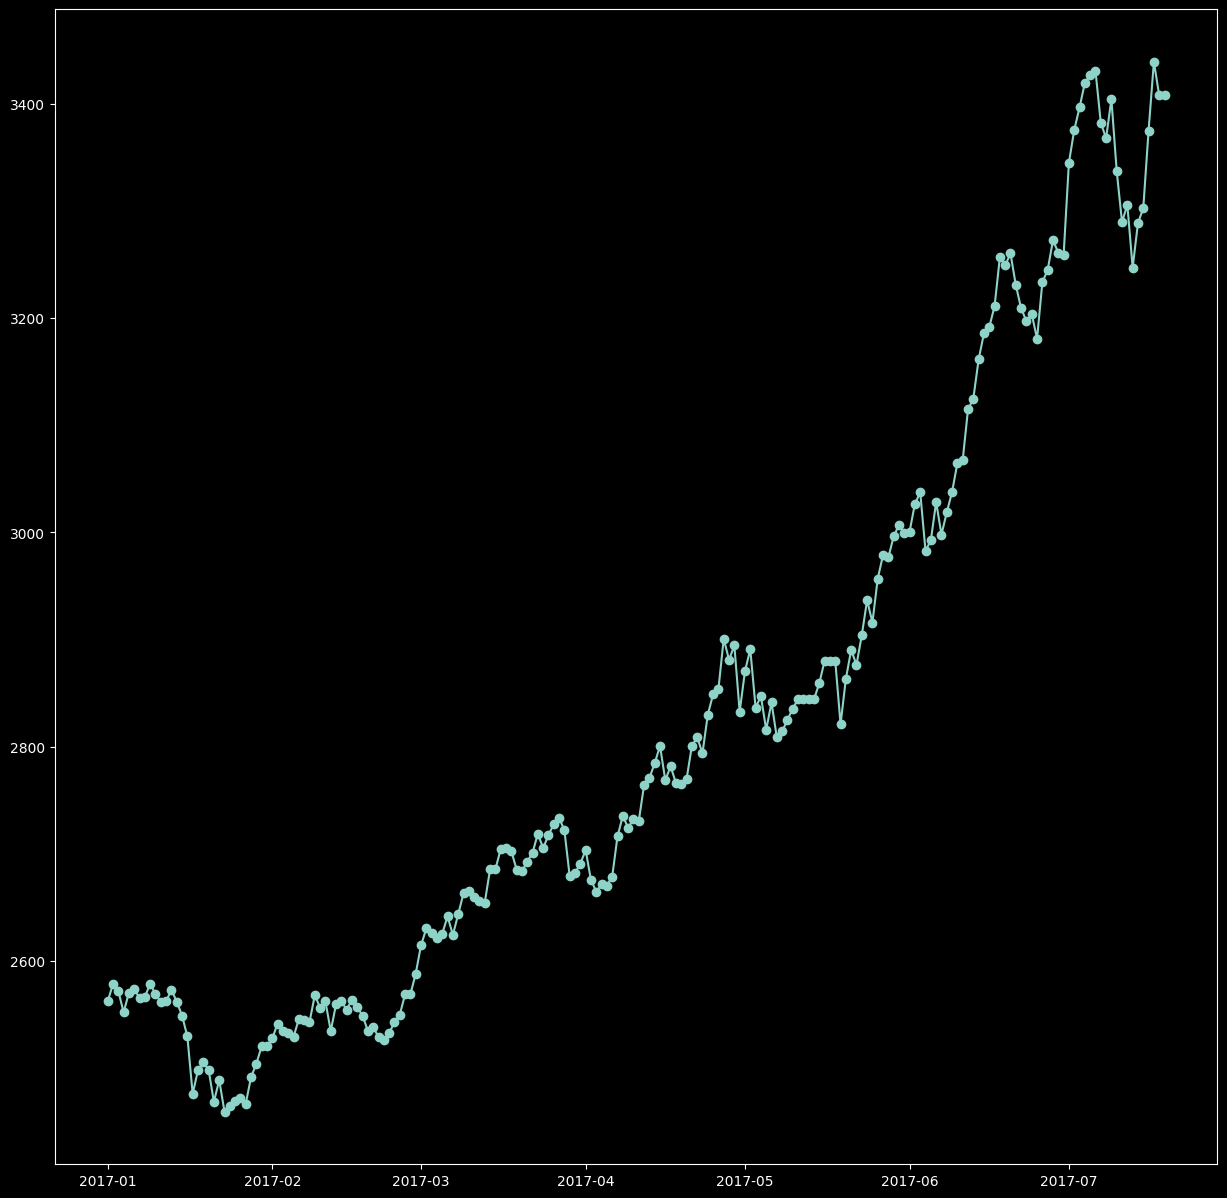

In [66]:
# Below is a plot of this time series
plt.figure(figsize = (15,15))
plt.plot(dax, marker = 'o')
plt.show()

In [67]:
# We'll start by standardizing the values of this time series so that the mean is 0 and the standard deviation is 1:
# It is recommended to do this before using complicated models.
dax_standard = (dax - np.mean(dax, axis = 0))/np.std(dax, axis = 0)
# This operation is reversible if you need to come back to the original values afterwards

<Figure size 1000x600 with 0 Axes>

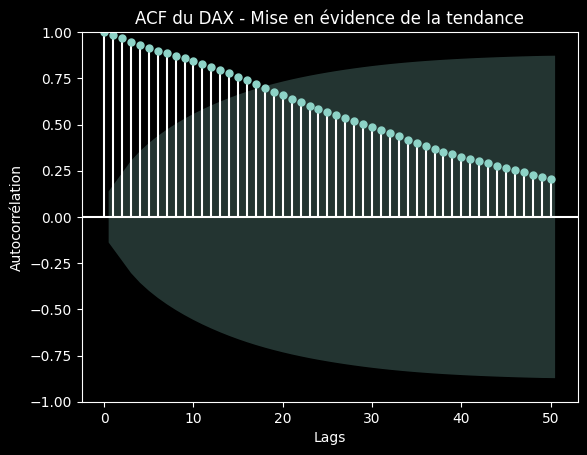

In [68]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_time_series_acf(series, lags=50, title="ACF Plot"):
    """
    Affiche l'ACF d'une série temporelle pour diagnostiquer la stationnarité.
    """
    plt.figure(figsize=(10, 6))
    plot_acf(series, lags=lags)
    plt.title(title)
    plt.xlabel("Lags")
    plt.ylabel("Autocorrélation")
    plt.savefig("dax_acf_plot.png")

# 2. Standardisation (Préconisé par le TP )
dax_standard = (dax - np.mean(dax, axis=0)) / np.std(dax, axis=0)

# 3. Génération du graphique
plot_time_series_acf(dax_standard, title="ACF du DAX - Mise en évidence de la tendance")

In [69]:
class TimeSeriesSplitter:
    """
    Classe responsable du découpage des données
    """
    @staticmethod
    def split_data(series, train_size):
        train = series.iloc[:train_size]
        validation = series.iloc[train_size:]
        return train, validation

# 1. Préparation (Standardisation incluse comme vu précédemment)
dax_standard = (dax - dax.mean()) / dax.std()

# 2. Application du Split (173 pour l'entraînement, le reste pour la validation)
train_size = 173
dax_train, dax_val = TimeSeriesSplitter.split_data(dax_standard, train_size)

# Vérification des dimensions
print(f"Taille du set d'entraînement : {len(dax_train)}")   # 173
print(f"Taille du set de validation   : {len(dax_val)}")     # 27

Taille du set d'entraînement : 173
Taille du set de validation   : 27


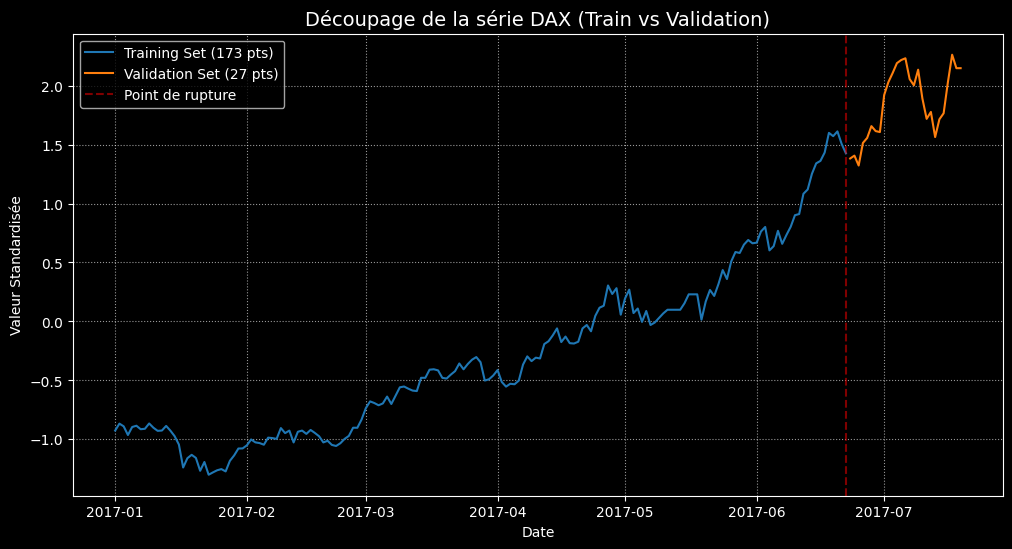

In [70]:
def plot_split_series(train, validation, title="DAX Split"):
    """
    Fonction dédiée uniquement à la visualisation du split.
    """
    plt.figure(figsize=(12, 6))

    # Tracé des deux sets avec des couleurs distinctes
    plt.plot(train.index, train.values, label=f'Training Set ({len(train)} pts)', color='#1f77b4')
    plt.plot(validation.index, validation.values, label=f'Validation Set ({len(validation)} pts)', color='#ff7f0e')

    # Esthétique et labels
    plt.title(title, fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Valeur Standardisée")
    plt.axvline(train.index[-1], color='red', linestyle='--', alpha=0.5, label='Point de rupture')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.savefig("dax_split_plot.png")

# Utilisation
plot_split_series(dax_train, dax_val, title="Découpage de la série DAX (Train vs Validation)")

In [71]:
# Creation of a double exponential smoothing model on the training data:
from statsmodels.tsa.api import Holt
double_es = Holt(dax_train, initialization_method = "estimated").fit()
double_es.summary()
# When you ask for ' initialization_method = "estimated" ', the initial values of the algorithm (a and b) and the alpha 
# and beta parameter are chosen by python so that the intermediate predictions are the best.
# You can also ask to fix alpha and beta of your choice by specifying smoothing_level = 'what you want' and smoothing_trend = 'what you want'
# as parameters of the fit() function

Dep. Variable:,Value,No. Observations:,173
Model:,Holt,SSE,0.901
Optimized:,True,AIC,-901.604
Trend:,Additive,BIC,-888.991
Seasonal:,None,AICC,-901.098
Seasonal Periods:,None,Date:,"Thu, 12 Feb 2026"
Box-Cox:,False,Time:,19:18:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8484936,alpha,True
smoothing_trend,0.0214299,beta,True


In [72]:
# for the level (called a in the CM)
double_es.level

2017-01-01   -0.924294
2017-01-02   -0.874832
2017-01-03   -0.886617
2017-01-04   -0.950932
2017-01-05   -0.903419
                ...   
2017-06-18    1.576884
2017-06-19    1.576514
2017-06-20    1.610684
2017-06-21    1.525003
2017-06-22    1.444457
Freq: D, Length: 173, dtype: float64

In [73]:
# for the trend (called b in the CM)
double_es.trend

2017-01-01    0.003798
2017-01-02    0.004776
2017-01-03    0.004422
2017-01-04    0.002949
2017-01-05    0.003904
                ...   
2017-06-18    0.029021
2017-06-19    0.028391
2017-06-20    0.028515
2017-06-21    0.026068
2017-06-22    0.023783
Freq: D, Length: 173, dtype: float64

In [74]:
# Extraction des dernières valeurs de a et b
# Dans statsmodels : level correspond à 'a' et trend à 'b'
a_last = double_es.level.iloc[-1]
b_last = double_es.trend.iloc[-1]

print(f"Valeur du niveau (a) au dernier instant : {a_last:.4f}")
print(f"Valeur de la pente (b) au dernier instant : {b_last:.4f}")

Valeur du niveau (a) au dernier instant : 1.4445
Valeur de la pente (b) au dernier instant : 0.0238


In [75]:
from abc import ABC, abstractmethod

class ForecastStrategy(ABC):
    @abstractmethod
    def predict(self, level, trend, horizon):
        pass

class LinearTrendStrategy(ForecastStrategy):
    """Implémentation du calcul linéaire pour le modèle de Holt (DES)"""
    def predict(self, level, trend, horizon):
        return level + horizon * trend

# Utilisation
strategy = LinearTrendStrategy()
pred_1 = strategy.predict(a_last, b_last, horizon=1)
pred_2 = strategy.predict(a_last, b_last, horizon=2)

print(f"Prédictions : {pred_1:.6f}, {pred_2:.6f}")

Prédictions : 1.468240, 1.492024


In [76]:
double_es.forecast(2)

2017-06-23    1.468240
2017-06-24    1.492024
Freq: D, dtype: float64

In [77]:
from sklearn.metrics import mean_squared_error

class ForecastingStrategy:
    """Interface pour les stratégies de prédiction."""
    def predict(self, train, steps):
        pass

class DESStrategy(ForecastingStrategy):
    """Implémentation spécifique pour le Double Exponential Smoothing."""
    def predict(self, train, steps):
        model = Holt(train, initialization_method="estimated").fit()
        return model.forecast(steps)

# Utilisation
strategy = DESStrategy()
des_preds = strategy.predict(dax_train, len(dax_val))

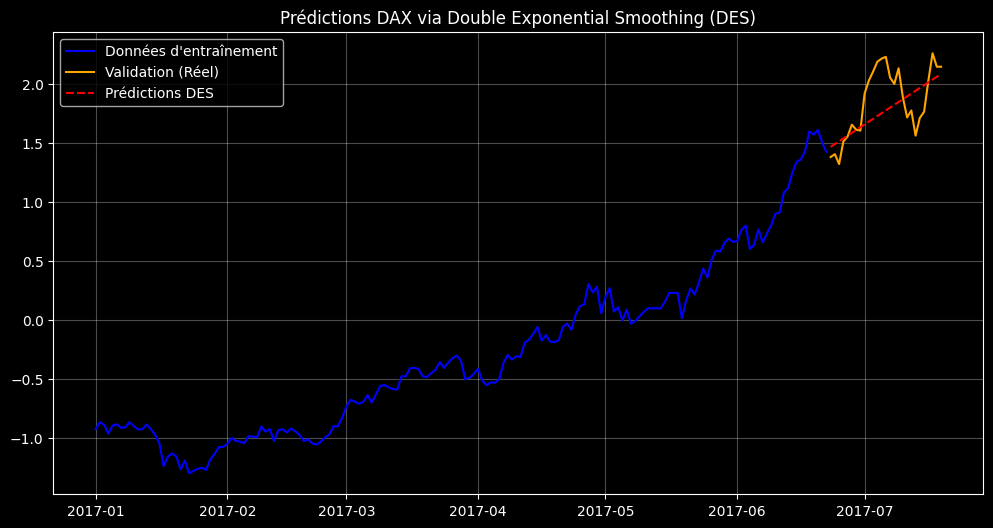

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(dax_train, label='Données d\'entraînement', color='blue')
plt.plot(dax_val, label='Validation (Réel)', color='orange')
plt.plot(dax_val.index, des_preds, label='Prédictions DES', color='red', linestyle='--')

plt.title("Prédictions DAX via Double Exponential Smoothing (DES)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("dax_des_predictions_plot.png")

In [79]:
# Calcul de l'erreur
mse_des = mean_squared_error(dax_val, des_preds)
print(f"L'erreur quadratique moyenne (MSE) est : {mse_des:.6f}")

L'erreur quadratique moyenne (MSE) est : 0.059012


## Classical Auto-regressive models

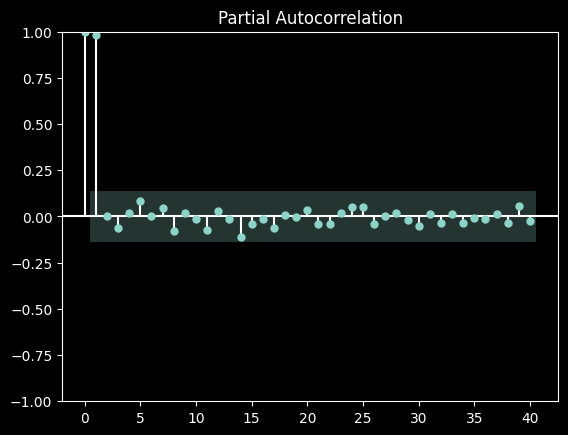

In [80]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(dax, lags=40)
# The PACF is plotted.
# You should see that the last big coefficient is obtained for a lag of 1
# so we will use order 1 in the following

In [81]:
from statsmodels.tsa.ar_model import AutoReg

class ModelSelector:
    """Classe pour sélectionner l'ordre optimal d'un modèle."""

    def __init__(self, data, max_lag=10):
        self.data = data
        self.max_lag = max_lag

    def find_best_lag(self):
        best_bic = float('inf')
        best_lag = 0

        for lag in range(1, self.max_lag + 1):
            # trend='c' pour AR classique avec constante
            model = AutoReg(self.data, lags=lag, trend='c').fit()
            if model.bic < best_bic:
                best_bic = model.bic
                best_lag = lag

        return best_lag, best_bic

# Utilisation
selector = ModelSelector(dax_train)
best_p, b_val = selector.find_best_lag()
print(f"L'ordre optimal selon le BIC est p = {best_p} (BIC = {b_val:.2f})")

L'ordre optimal selon le BIC est p = 1 (BIC = -398.26)


In [82]:
class ARModel:
    def __init__(self, lags=1, trend='c'):
        self.lags = lags
        self.trend = trend
        self.results = None

    def fit(self, data):
        # Initialisation et entraînement du modèle AutoReg
        model = AutoReg(data, lags=self.lags, trend=self.trend)
        self.results = model.fit()
        return self.results

# 1. Création de l'instance pour un AR(1)
ar_strategy = ARModel(lags=1)

# 2. Entraînement sur dax_train (les 173 premiers points)
ar_results = ar_strategy.fit(dax_train)

# 3. Affichage du résumé statistique
print(ar_results.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Value   No. Observations:                  173
Model:                     AutoReg(1)   Log Likelihood                 206.850
Method:               Conditional MLE   S.D. of innovations              0.073
Date:                Thu, 12 Feb 2026   AIC                           -407.700
Time:                        19:18:30   BIC                           -398.258
Sample:                    01-02-2017   HQIC                          -403.869
                         - 06-22-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.006      2.740      0.006       0.005       0.028
Value.L1       1.0094      0.008    129.494      0.000       0.994       1.025
                                    Roots           

In [83]:
class PredictionStrategy(ABC):
    """Interface SOLID pour définir une stratégie de prédiction."""
    @abstractmethod
    def fit_predict(self, train, steps):
        pass

class ARStrategy(PredictionStrategy):
    """Implémentation de la stratégie Auto-Régressive."""
    def __init__(self, lags=1, trend='c'):
        self.lags = lags
        self.trend = trend

    def fit_predict(self, train, steps):
        # Entraînement du modèle AutoReg
        model = AutoReg(train, lags=self.lags, trend=self.trend).fit()
        # Génération des prédictions (forecast)
        return model.forecast(steps)

# Calculs et Évaluation
# Instanciation du modèle AR(1) sélectionné par le critère BIC
ar_strategy = ARStrategy(lags=1)
ar_predictions = ar_strategy.fit_predict(dax_train, len(dax_val))

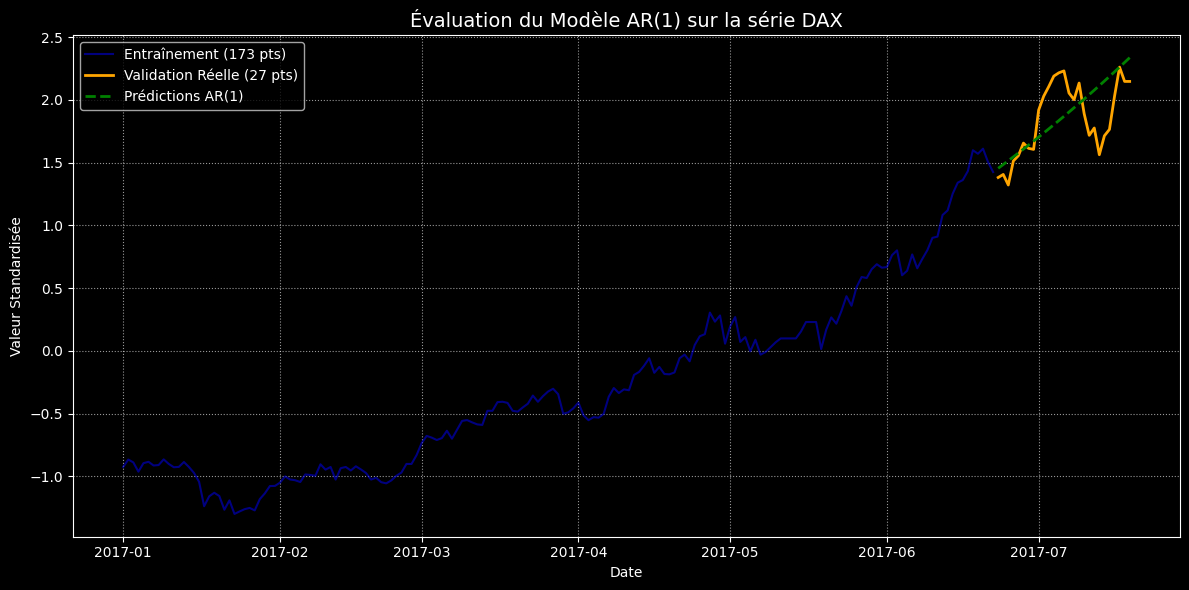

In [84]:
# Visualisation
plt.figure(figsize=(12, 6))

# Tracé des données historiques et réelles
plt.plot(dax_train.index, dax_train.values, label='Entraînement (173 pts)', color='blue', alpha=0.5)
plt.plot(dax_val.index, dax_val.values, label='Validation Réelle (27 pts)', color='orange', linewidth=2)

# Tracé des prédictions AR(1)
plt.plot(dax_val.index, ar_predictions, label='Prédictions AR(1)', color='green', linestyle='--', linewidth=2)

# Cosmétique
plt.title("Évaluation du Modèle AR(1) sur la série DAX", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Valeur Standardisée")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

# Sauvegarde et affichage
plt.savefig("dax_ar_complete_plot.png")
plt.show()

In [85]:
# Calcul de l'erreur quadratique moyenne
mse_ar = np.mean((dax_val.values.flatten() - ar_predictions.values.flatten())**2)
print(f"MSE pour le modèle AR(1) : {mse_ar:.6f}")

MSE pour le modèle AR(1) : 0.065349


## Auto-regressive models with trend

Equation :

$$y_t = \phi_0 + \phi_1 y_{t-1} + \delta t + \epsilon_t$$

Où :
$y_t$ est la valeur de la série à l'instant
$t$.$\phi_0$ est la constante (intercept).$\phi_1$ est le coefficient d'auto-régression associé à la valeur précédente
$y_{t-1}$.$\delta$ (delta) est le coefficient de la tendance linéaire ($t$ représente l'indice temporel $1, 2, 3, \dots$).
$\epsilon_t$ est le bruit blanc (erreur résiduelle) à l'instant $t$, que l'on suppose suivre une loi normale $\mathcal{N}(0, \sigma^2)$.

In [86]:
class ModelStrategy(ABC):
    @abstractmethod
    def fit(self, data):
        pass

class ARTModel(ModelStrategy):
    """Implémentation du modèle Auto-Régressif avec Tendance."""
    def __init__(self, lags=1):
        self.lags = lags

    def fit(self, data):
        # 'ct' signifie constant + trend (t)
        return AutoReg(data, lags=self.lags, trend='ct').fit()

# Exécution sur le set d'entraînement (173 points)
art_strategy = ARTModel(lags=1)
mod = art_strategy.fit(dax_train)

# Extraction des paramètres estimés
params = mod.params
print("Paramètres estimés du modèle ART(1) :")
print(params)

Paramètres estimés du modèle ART(1) :
const      -0.068616
trend       0.000795
Value.L1    0.957275
dtype: float64


In [87]:
class ARTForecastCalculator:
    """
    Classe dédiée au calcul manuel des prédictions ART(1)
    """
    @staticmethod
    def calculate_next_value(params, last_value, t_index):
        phi_0 = params['const']
        phi_1 = params['Value.L1']
        delta = params['trend']

        return phi_0 + phi_1 * last_value + delta * t_index

# Utilisation des paramètres du modèle entraîné
params = mod.params
last_y = dax_train.iloc[-1].values[0]
t_next = len(dax_train) + 1  # 174

prediction = ARTForecastCalculator.calculate_next_value(params, last_y, t_next)
print(f"La prédiction pour la première valeur de validation est : {prediction:.6f}")

La prédiction pour la première valeur de validation est : 1.434146


In [88]:
#You can find this value automatically by the command : 
mod.forecast(1)

2017-06-23    1.434146
Freq: D, dtype: float64

In [89]:
class ARTOrderSelector:
    """
    Classe respectant le SRP (Single Responsibility Principle)
    pour identifier l'ordre p optimal selon le BIC.
    """
    def __init__(self, data, max_lag=10):
        self.data = data
        self.max_lag = max_lag

    def get_best_order(self):
        bic_results = {}

        for p in range(1, self.max_lag + 1):
            # 'ct' définit le modèle ART (Constant + Trend)
            model = AutoReg(self.data, lags=p, trend='ct').fit()
            bic_results[p] = model.bic

        # Sélection de l'ordre avec le BIC le plus bas
        best_p = min(bic_results, key=bic_results.get)
        return best_p, bic_results

# --- Exécution ---
selector = ARTOrderSelector(dax_train)
best_p, all_bics = selector.get_best_order()

print(f"Résultats BIC par ordre (p) :")
for p, bic in all_bics.items():
    print(f"Ordre {p}: BIC = {bic:.4f}")

print(f"\nLe meilleur modèle est l'ART({best_p}) avec un BIC de {all_bics[best_p]:.4f}")

Résultats BIC par ordre (p) :
Ordre 1: BIC = -399.1875
Ordre 2: BIC = -395.7319
Ordre 3: BIC = -387.3030
Ordre 4: BIC = -381.1427
Ordre 5: BIC = -375.5306
Ordre 6: BIC = -368.0591
Ordre 7: BIC = -359.6120
Ordre 8: BIC = -354.4416
Ordre 9: BIC = -349.3477
Ordre 10: BIC = -344.5001

Le meilleur modèle est l'ART(1) avec un BIC de -399.1875


In [90]:
class PredictionStrategy(ABC):
    @abstractmethod
    def fit_predict(self, train, steps):
        pass

class ARTStrategy(PredictionStrategy):
    """Modèle Auto-Régressif avec Tendance (ART)"""
    def __init__(self, lags=1):
        self.lags = lags

    def fit_predict(self, train, steps):
        # 'ct' = constant + trend
        model = AutoReg(train, lags=self.lags, trend='ct').fit()
        return model.forecast(steps)

# Calculs et Évaluation
# Utilisation du modèle optimal sélectionné par le BIC (ordre 1)
art_strategy = ARTStrategy(lags=1)
art_predictions = art_strategy.fit_predict(dax_train, len(dax_val))

# Calcul de l'erreur quadratique moyenne (MSE)
mse_art = np.mean((dax_val.values.flatten() - art_predictions.values.flatten())**2)

In [91]:
print(f"--- Résultats du modèle ART(1) ---")
print(f"MSE sur le set de validation : {mse_art:.6f}")

--- Résultats du modèle ART(1) ---
MSE sur le set de validation : 0.128669


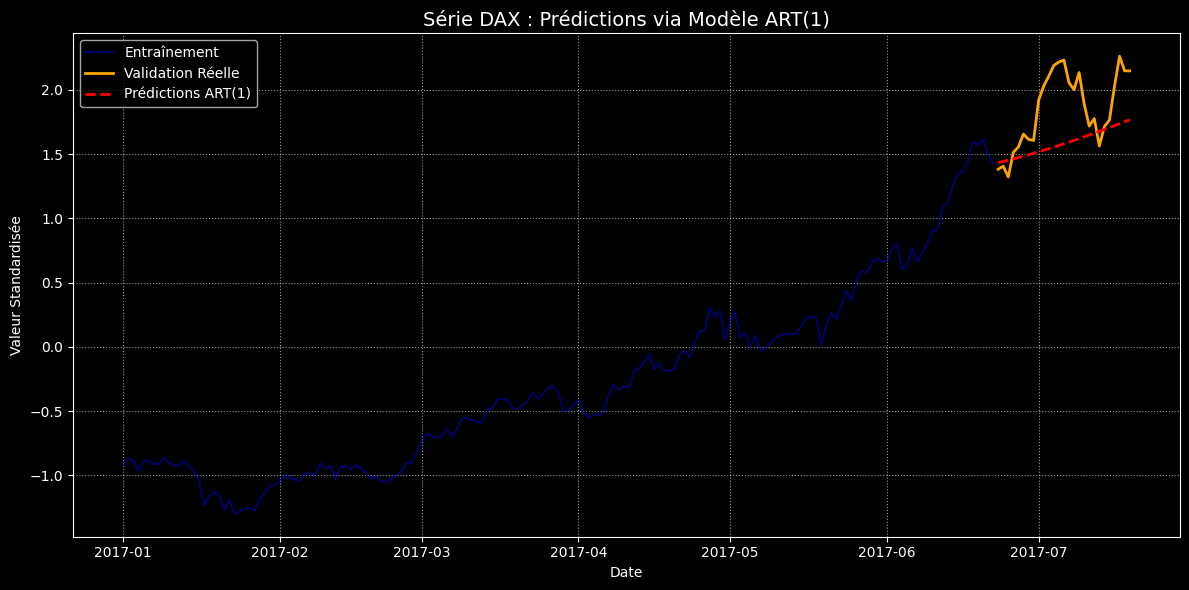

In [92]:
plt.figure(figsize=(12, 6))

# Tracé des données
plt.plot(dax_train.index, dax_train.values, label='Entraînement', color='blue', alpha=0.4)
plt.plot(dax_val.index, dax_val.values, label='Validation Réelle', color='orange', linewidth=2)
plt.plot(dax_val.index, art_predictions, label='Prédictions ART(1)', color='red', linestyle='--', linewidth=2)

# Point de rupture
plt.axvline(dax_train.index[-1], color='black', linestyle=':', alpha=0.5)

# Cosmétique
plt.title("Série DAX : Prédictions via Modèle ART(1)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Valeur Standardisée")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

plt.show()

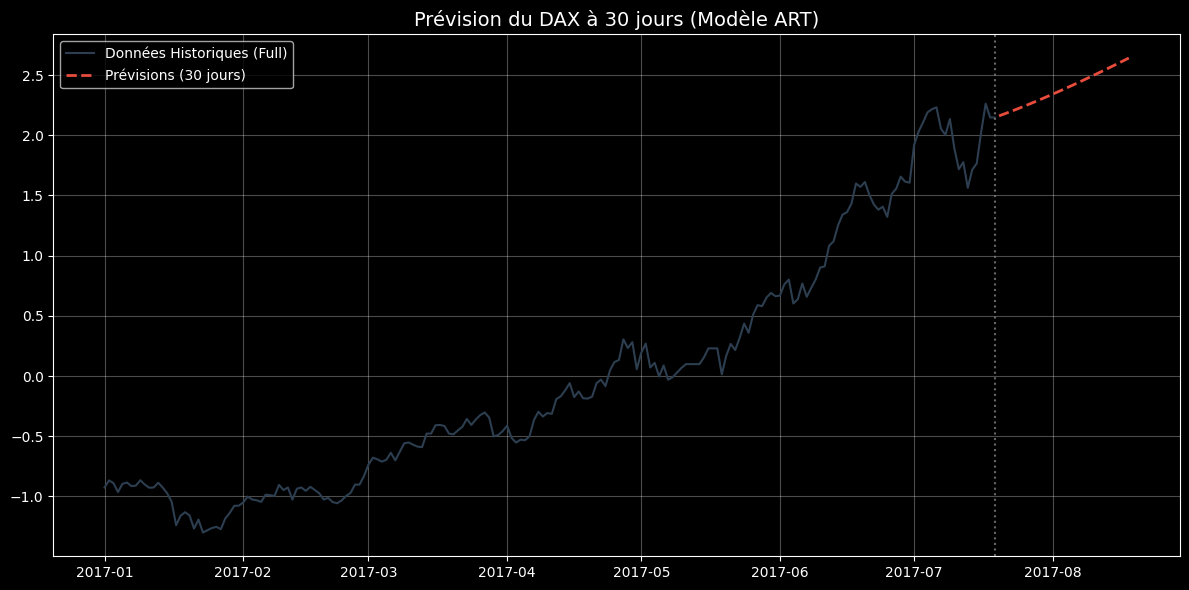

In [93]:
# 1. Utilisation de la série complète (Training + Validation)
dax_full = dax_standard # Contient les 200 points

# 2. Création du modèle final (ART d'ordre 1)
# Nous utilisons 'ct' pour maintenir la constante et la tendance
final_model = AutoReg(dax_full, lags=1, trend='ct').fit()

# 3. Prédiction des 30 points futurs
# On demande 30 points après la fin de la série (horizon h=30)
forecast_steps = 30
future_forecast = final_model.forecast(steps=forecast_steps)

# 4. Création des nouveaux index temporels pour le futur
last_date = dax_full.index[-1]
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1),
                             periods=forecast_steps, freq='D')
future_series = pd.Series(future_forecast.values, index=future_index)

# ---------------------------------------------------------
# 5. Visualisation Finale
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# Historique complet
plt.plot(dax_full.index, dax_full.values, label='Données Historiques (Full)', color='#2c3e50')

# Prédictions futures
plt.plot(future_series.index, future_series.values,
         label='Prévisions (30 jours)', color='#e74c3c', linestyle='--', linewidth=2)

# Décoration
plt.title("Prévision du DAX à 30 jours (Modèle ART)", fontsize=14)
plt.axvline(last_date, color='grey', linestyle=':', alpha=0.8)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()